# Crime vs Population

Dataset: https://www.kaggle.com/marshallproject/crime-rates

The goal in this notebook is to present how does a linear regression model actually works. For this purpouse I will implement the gradient descent algorithm by hand and compare the results of sklearn. This exercise is inspired by the Andrew Ng course of Machine Learning.

The usecase is to see if there is a correlation between crime vs population. 

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib notebook

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.filterwarnings(action="ignore", module="sklearn", message="^Objective did not")

import locale
locale.setlocale(locale.LC_NUMERIC, '')
pd.options.display.float_format = '{:0,.02f}'.format
np.set_printoptions(suppress=True)

## Load Data

In [2]:
all_data = pd.read_csv('data/report.csv')
print(all_data.shape)
print(all_data.describe())

(2829, 15)
       report_year   population  violent_crimes  homicides    rapes  assaults  \
count     2,829.00     2,760.00        2,794.00   2,795.00 2,754.00  2,753.00   
mean      1,995.00   795,698.09       29,632.55     398.39   416.28  4,405.15   
std          11.83 1,012,450.57      172,863.02   2,281.28   479.81  6,977.29   
min       1,975.00   100,763.00          154.00       1.00    15.00     15.00   
25%       1,985.00   377,931.00        3,014.75      32.00   176.25  1,467.00   
50%       1,995.00   536,614.50        5,135.50      64.00   291.00  2,597.00   
75%       2,005.00   816,855.75        9,058.50     131.00   465.00  4,556.00   
max       2,015.00 8,550,861.00    1,932,274.00  24,703.00 3,899.00 71,030.00   

       robberies  months_reported  crimes_percapita  homicides_percapita  \
count   2,754.00         2,692.00          2,794.00             2,795.00   
mean    4,000.25            11.87          1,093.05                15.37   
std     8,653.90             1.

In [3]:
all_data[all_data.report_year == 2015][:5]

,report_year,agency_code,agency_jurisdiction,population,violent_crimes,homicides,rapes,assaults,robberies,months_reported,crimes_percapita,homicides_percapita,rapes_percapita,assaults_percapita,robberies_percapita
2760,2015,NM00101,"Albuquerque, NM","559,721.00","5,406.00",43.00,404.00,"3,273.00","1,686.00",nan,965.84,7.68,72.18,584.76,301.22
2761,2015,TX22001,"Arlington, TX","387,565.00","1,946.00",8.00,208.00,"1,201.00",529.00,nan,502.11,2.06,53.67,309.88,136.49
2762,2015,GAAPD00,"Atlanta, GA","464,710.00","5,203.00",94.00,170.00,"2,944.00","1,995.00",nan,"1,119.62",20.23,36.58,633.51,429.30
2763,2015,CO00101,"Aurora, CO","360,237.00","1,660.00",24.00,352.00,837.00,447.00,nan,460.81,6.66,97.71,232.35,124.08
2764,2015,TX22701,"Austin, TX","938,728.00","3,497.00",23.00,487.00,"2,058.00",929.00,nan,372.53,2.45,51.88,219.23,98.96


I'll simplify my task for now and use the latest year to build my model

In [4]:
latest_report = all_data[all_data.report_year == 2000]
latest_report = latest_report[pd.notnull(latest_report['population'])]
latest_report = latest_report[pd.notnull(latest_report['violent_crimes'])]
X = latest_report[['population']]

# Here we preform feature scaling. This is good practice and is also needed for this dataset - without it we get overflow
X = (X - X.mean())/X.std()

X.insert(0, 'ones', 1)
X = X.as_matrix()

y = latest_report[['violent_crimes']]
m = len(y)

<IPython.core.display.Javascript object>


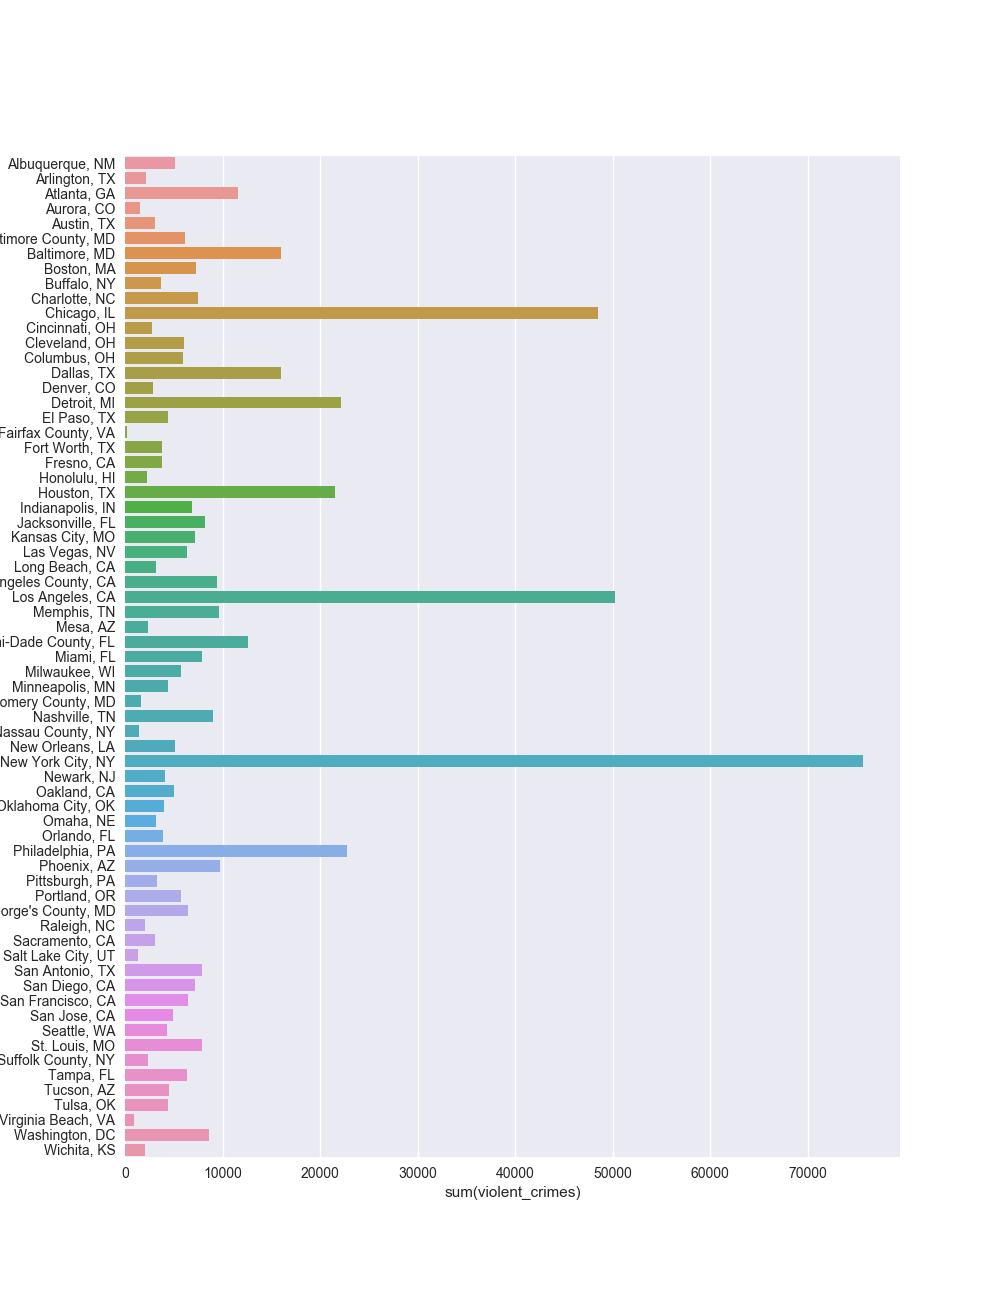

In [5]:
plt.figure(figsize=(10,13))
sns.barplot(latest_report['violent_crimes'], y=latest_report["agency_jurisdiction"],estimator=sum ,ci=0)

## Visualize Data

In [6]:
def plot_scatter_line(X, y, theta, title='', xlabel='', ylabel=''):
    X = X[:, 1]
    interval = np.linspace(X.min(), X.max())
    result = interval * theta[1] + theta[0]

    plt.figure()
    plt.plot(interval, result, '-r')
    plt.scatter(X, y, marker='x')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

def plot_learning_curve(cost_history):
    plt.figure()
    plt.title('Learning curve')
    plt.xlabel('Iterations')
    plt.ylabel('J(theta)')
    plt.plot(cost_history)

A naive way to solve this problem is to get the mean value:

<IPython.core.display.Javascript object>


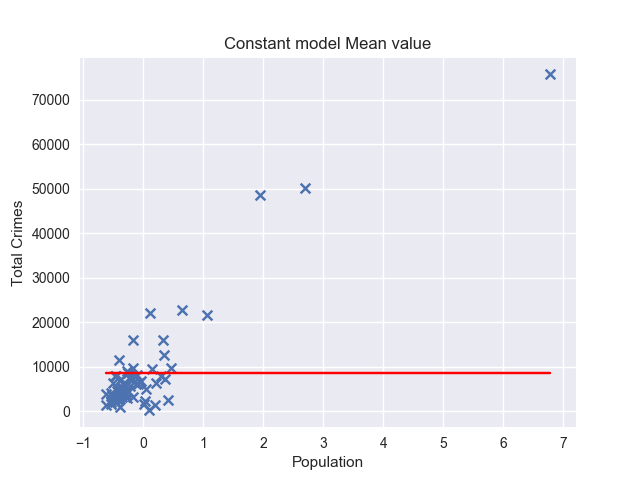

In [7]:
plot_scatter_line(X, y, np.array([[y.mean()], [0]]), title='Constant model Mean value', xlabel='Population', ylabel='Total Crimes')

## Cost function

We mesure the difference of our hypothesis and the actual $y$ using the cost function $J$ that takes the parameter vector $\theta$ as argument. The definition of $J$ is the following:

$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2$

where $h_{\theta}(x) = \theta^Tx = \theta_0x_0 + \theta_1x_1 $ and $x_0 = 1$. In our usecase $\theta_0$ is something like base minimal number of crimes for any population (it is called intercept parameter). The forumla for $J$ is basically the average squared distance between prediction and expected values devided by two so that we get convergance when we get the derivative - more on that latter.

In [8]:
def get_cost(X, y, theta):
    m = len(y)
    h_theta = np.dot(X, theta)
    squared_dist = np.power(h_theta - y.values, 2)
    
    return np.sum(squared_dist)/(2*m)

## Finding parameters using gradient descent

Our goal is to minimize $J(\theta)$, therefore we need to find $\theta$ that gives the (hopefuly) the global minimum of $J$.
One way to do so is to take small steps (with length $\alpha$) in direction of the steepest descent. That means we should find the partial derivatives of $J$ with respect of each individual parameter.
The partial derivatives are (assuming $x_0 = 1$):

$\frac{\partial J}{\partial \theta} = \frac{1}{m} \sum_{i=0}^{m} (h_\theta(x^{(i)}) - y^{(i)})x^{(i)}$

The way that we take steps is the following:

$\theta_j := \theta_j - \alpha \frac{\partial J}{\partial \theta_j}$


In [9]:
print(X.shape)
X[:5]

(67, 2)


array([[ 1.        , -0.36453843],
       [ 1.        , -0.47376977],
       [ 1.        , -0.39489117],
       [ 1.        , -0.5272113 ],
       [ 1.        , -0.1681047 ]])

In [10]:
def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    cost_history = []

    for i in range(iterations):
        if len(cost_history) > 2 and cost_history[i - 2] == cost_history[i-1]:
            break

        h = X.dot(theta)
        y_diff = h - y
        partials = 1/m * (np.multiply(X, y_diff).sum(axis=0))     
                
        theta = theta - alpha * partials.T
        cost_history.append(get_cost(X, y, theta))

    return theta, cost_history

In [11]:
theta, cost_history = gradient_descent(X, y, np.matrix('0; 0'), 0.1, 100)
print(theta)

[[  8572.56333945]
 [ 11078.74311789]]


<IPython.core.display.Javascript object>


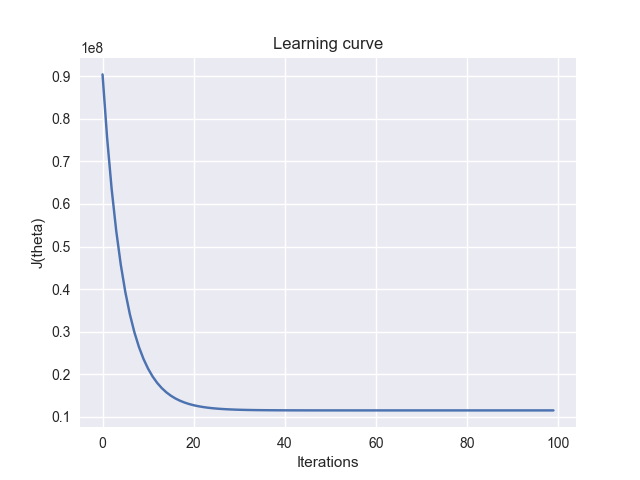

In [12]:
plot_learning_curve(cost_history)

<IPython.core.display.Javascript object>


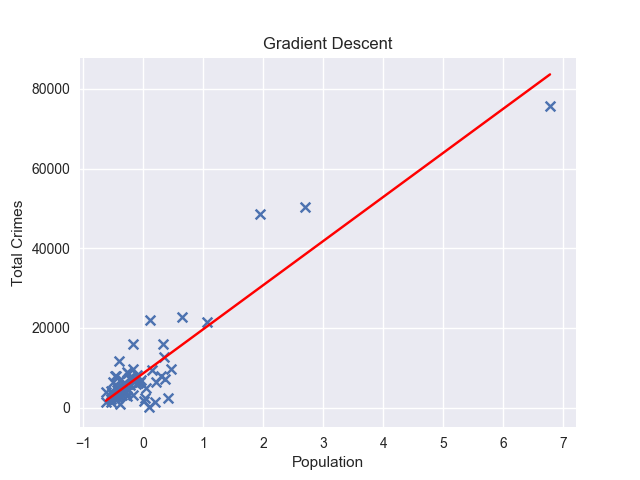

In [13]:
plot_scatter_line(X, y, [theta.item(0), theta.item(1)], title='Gradient Descent', xlabel='Population', ylabel='Total Crimes')

Lets compare the results with the sklearn LinearRegression model:

8572.79104478 11079.0904282


<IPython.core.display.Javascript object>


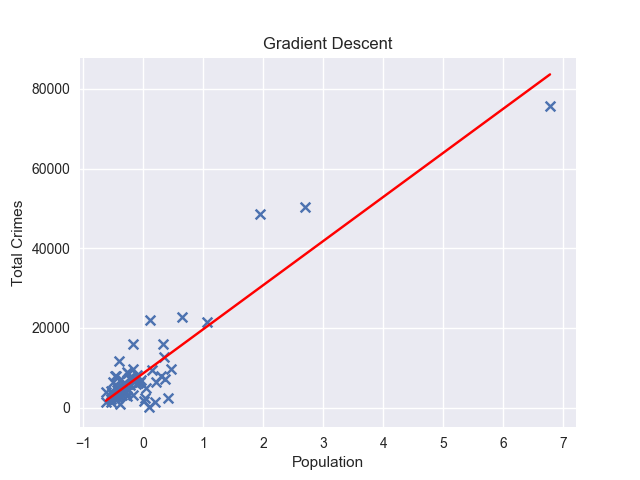

In [14]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X, y)
theta_0, theta_1 = model.intercept_[0], model.coef_[0][1]
print(theta_0, theta_1)
plot_scatter_line(X, y, [theta_0, theta_1], title='Gradient Descent', xlabel='Population', ylabel='Total Crimes')

## Finding parameters using normal equestions method

This is analytical method for finding the parameters. It does not need learning step. The down side is that it does not scale well. The complexity is $O^3$.

In [15]:
theta = np.linalg.pinv(X.T.dot(X)).dot(X.T.dot(y))
theta

array([[  8572.79104478],
       [ 11079.09042822]])

<IPython.core.display.Javascript object>


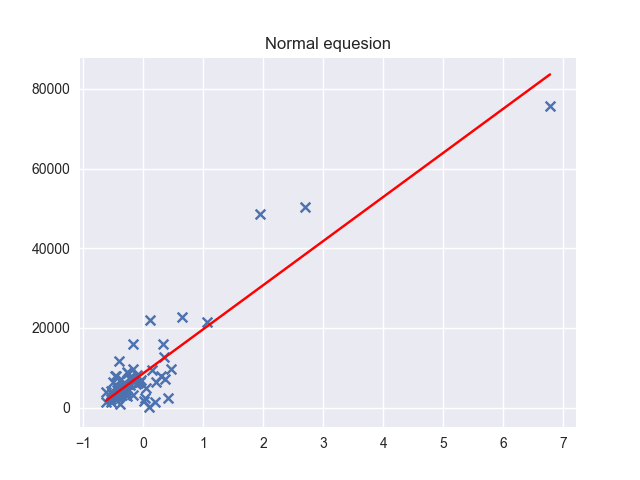

In [16]:
plot_scatter_line(X, y, theta, 'Normal equesion')

## Population vs Profit

The same function can be used to model simular problems. For example lets use it on the dataset provided in the Andrew Ng course for assigment 1 (you will have to join the course to get this one :)

In [17]:
pd.options.display.float_format = '{:0,.04f}'.format

data = pd.read_csv('data/population_vs_profit.csv')
X = data[['population']]
y = data[['profit']]
m = y.size
data.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


<IPython.core.display.Javascript object>


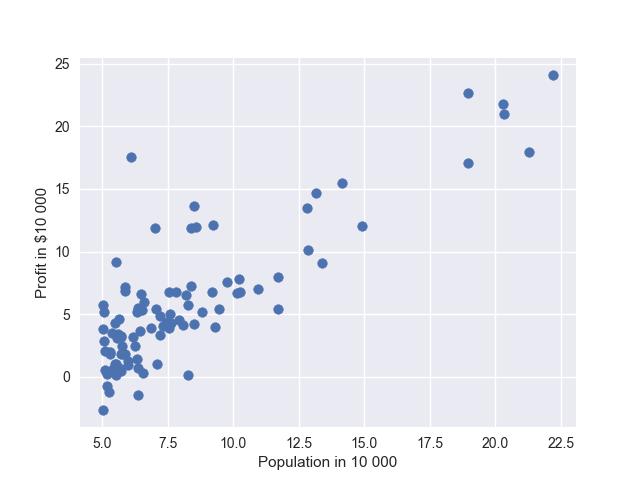

In [18]:
plt.figure()
plt.xlabel('Population in 10 000')
plt.ylabel('Profit in $10 000')
plt.scatter(X, y)

In [19]:
X.insert(0, 'ones', 1)
X = X.as_matrix()
theta, cost_history = gradient_descent(X, y, np.matrix('0; 0'), 0.01, 1500)
theta_0 = theta.item(0)
theta_1 = theta.item(1)

<IPython.core.display.Javascript object>


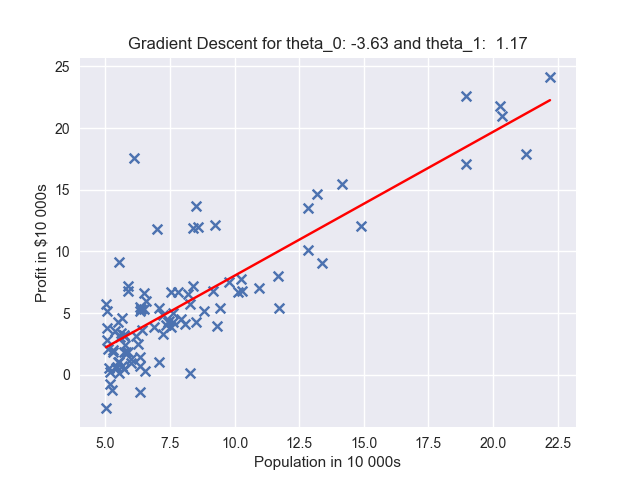

In [20]:
plot_scatter_line(X, y, [theta_0, theta_1],
                  title='Gradient Descent for theta_0: {0: 0.02f} and theta_1: {1: 0.02f}'.format(theta_0, theta_1, '0.02f'),
                  xlabel='Population in 10 000s',
                  ylabel='Profit in $10 000s')

<IPython.core.display.Javascript object>


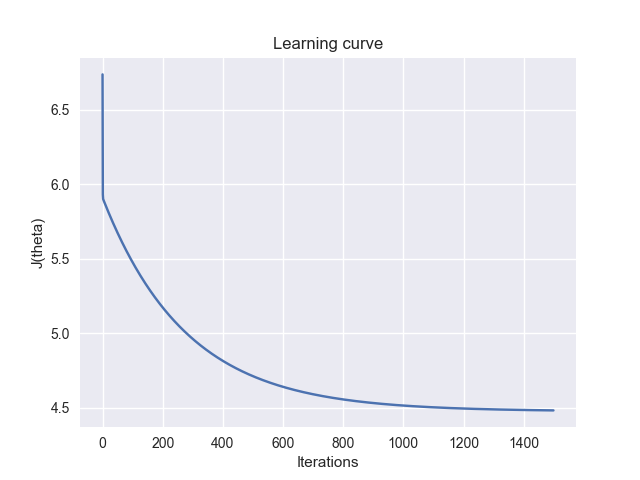

In [21]:
plt.figure()
plt.title('Learning curve')
plt.xlabel('Iterations')
plt.ylabel('J(theta)')
plt.plot(cost_history)

In [22]:
print(get_cost(X, y, [[-1], [2]]))
print(get_cost(X, y, [[0], [0]]))

54.242455082
32.0727338775


In [23]:
theta_0_vals = np.linspace(-10, 10, 100)
theta_1_vals = np.linspace(-1, 4, 100)

j_vals = []

for i in theta_0_vals:
    j_i_vals = []
    for j in theta_1_vals:
        cost = get_cost(X, y, [[i], [j]])
        j_i_vals.append(cost)
    j_vals.append(j_i_vals)
    
np.matrix(j_vals)

matrix([[ 328.09290555,  316.6648683 ,  305.44447299, ...,  186.35412584,
          195.06735595,  203.98822799],
        [ 323.26504192,  311.92025945,  300.7831189 , ...,  189.60197489,
          198.39845977,  207.40258658],
        [ 318.47799046,  307.21646275,  296.16257698, ...,  192.89063611,
          201.77037576,  210.85775734],
        ..., 
        [  49.81156018,   46.45923561,   43.31455298, ...,  691.41691065,
          708.20585345,  725.20243817],
        [  48.94247627,   45.67340647,   42.61197861, ...,  698.62353943,
          715.49573699,  732.57557648],
        [  48.11420452,   44.9283895 ,   41.95021641, ...,  705.87098036,
          722.82643269,  739.98952696]])

-3.6302914394043606 1.166362350335582


<IPython.core.display.Javascript object>


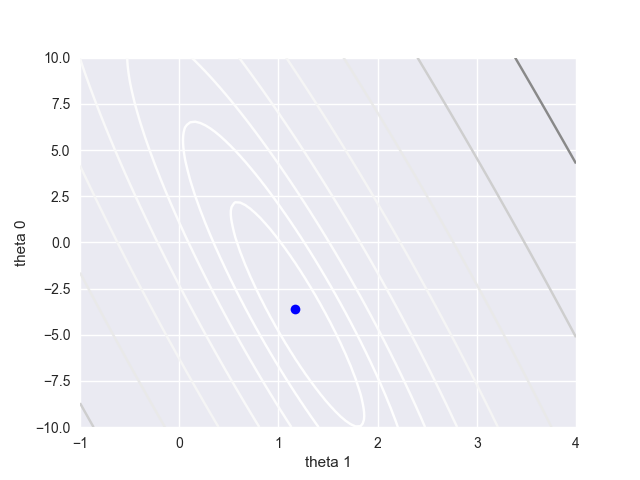

In [24]:
print(theta_0, theta_1)
plt.figure()
plt.xlabel('theta 1')
plt.ylabel('theta 0')
plt.plot(theta_1, theta_0, 'bo')
plt.contour(theta_1_vals, theta_0_vals, j_vals, np.logspace(-2, 3, 20))


## Linear regression with multiple variables

The above implementation will work even if we have more then single variable (feature) by which we predict. This is because We are using vectors and operations that work on vectors. For example, instead of using only `population`, we could include another feature - `report_year`

In [25]:
latest_report = all_data.copy()
latest_report = all_data[all_data.report_year > 2000]
latest_report = latest_report[pd.notnull(latest_report['population'])]
latest_report = latest_report[pd.notnull(latest_report['violent_crimes'])]
latest_report = latest_report[pd.notnull(latest_report['report_year'])]
X = latest_report[['population', 'report_year']]

# Here we preform feature scaling. This is good practice and is also needed for this dataset - without it we get overflow
X = (X - X.mean())/X.std()
# population_mean = X['population'].mean()
# population_std = X['population'].std()

# X_population = (X['population'] - population_mean)/population_std
# X = pd.concat([X_population, X['report_year']], axis=1)

X.insert(0, 'ones', 1)
X = X.as_matrix()

y = latest_report[['violent_crimes']]
m = len(y)

In [26]:
theta, cost_history = gradient_descent(X, y, np.matrix('0; 0; 0'), 0.1, 100)
print(theta)

[[ 7149.75984103]
 [ 7493.41540395]
 [ -882.18471688]]


<IPython.core.display.Javascript object>


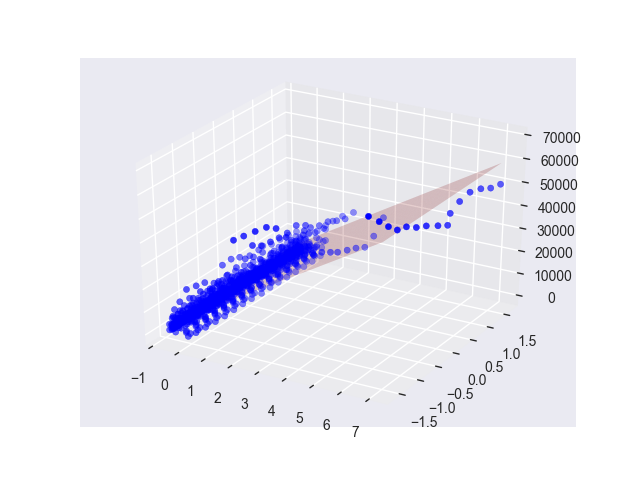

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X_1 = X[:, 1]
X_2 = X[:, 2]

x1 = np.linspace(X_1.min(), X_1.max())
x2 = np.linspace(X_2.min(), X_2.max())

xx, yy = np.meshgrid(x1, x2)

t1 = x1 * theta.item(1)
t2 = x2 * theta.item(2)
plane = theta.item(0) + t1 + t2

fig.xlabel = 'Population (in 10 000)'
fig.ylabel = 'Year (Normalized)'
fig.zlabel = 'Total Crimes (yr)'

ax.plot_surface(xx, yy, plane, color=(1.,0.,0.,0.2))
ax.scatter(X_1, X_2, y, color='blue')
